<a href="https://colab.research.google.com/github/HosnawHb/Blood_Glucose_Prediction/blob/main/BGP_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.layers import Input
from keras.layers import SimpleRNN
from keras.layers import Dense, Dropout
from keras.layers import LSTM, BatchNormalization, Bidirectional,GRU
from keras.layers import concatenate
from keras import Model
from keras.models import Sequential
import datetime
from keras.callbacks import ModelCheckpoint
import csv
import pickle
from sklearn.preprocessing import MinMaxScaler

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/XPH5", 'rb') as f:
    X = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/XPH10", 'rb') as f:
    X10 = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/XPH15", 'rb') as f:
    X15 = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/yPH5", 'rb') as f:
    y = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/yPH10", 'rb') as f:
    y10 = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/CGM/yPH15", 'rb') as f:
    y15 = pickle.load(f)

In [ ]:
X = np.reshape(X, (len(X), len(X[1])))
y = np.reshape(y, (len(y), 1))

In [ ]:
X10 = np.reshape(X10, (len(X10), len(X10[1])))
y10 = np.reshape(y10, (len(y10), 1))

In [ ]:
X15 = np.reshape(X15, (len(X15), len(X15[1])))
y15 = np.reshape(y15, (len(y15), 1))

In [ ]:
X[2]

array([377., 251., 257., 251., 243.])

In [ ]:
X.shape, y.shape

NameError: ignored

In [ ]:
X10.shape, y10.shape

((117099, 5), (117099, 1))

In [ ]:
X15.shape, y15.shape

((116186, 5), (116186, 1))

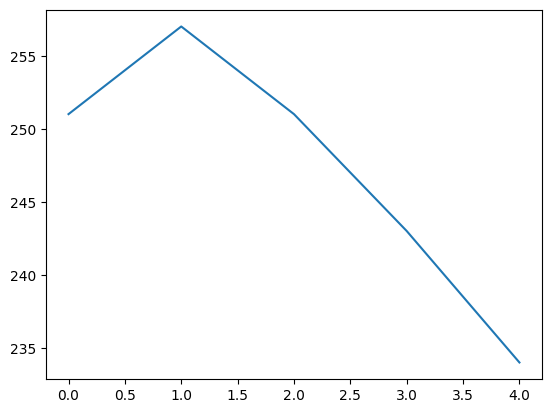

In [ ]:
plt.plot(X[3])
plt.show()

In [ ]:
def report(history,epoch = 20):
  #plotting train and validation loss
  loss_train = history.history['root_mean_squared_error']
  loss_val = history.history['val_root_mean_squared_error']
  epochs = range(0,epoch)
  plt.plot(epochs,loss_train,'g',label='Training rmse')
  plt.plot(epochs,loss_val,'b',label='Validation rmse')
  plt.title('Training and Validation rmse')
  plt.xlabel('Epochs')
  plt.ylabel('RMSE')
  plt.legend()
  plt.show()
  print()

In [ ]:
def CreateModel():
  model = Sequential()
  model.add(LSTM(16,input_shape=(5,1),return_sequences=True))
  #model.add(BatchNormalization())
  #model.add(BatchNormalization())
 # model.add(LSTM(50, return_sequences=True))
  #model.add(LSTM(30))
  model.add(LSTM(8))
  model.add(Dense(16))
  model.add(Dense(8))
  model.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  #checkpath = "weight.hdf5"
  #checkpoint = ModelCheckpoint(filepath=checkpath,monitor = 'val_loss',mode = 'min',save_best_only = True)
  model.compile(optimizer=opt,loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  return model

In [ ]:
model = CreateModel()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 5, 16)             1152      
                                                                 
 lstm_23 (LSTM)              (None, 8)                 800       
                                                                 
 dense_33 (Dense)            (None, 16)                144       
                                                                 
 dense_34 (Dense)            (None, 8)                 136       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def splitter(X,y,testPercent):
  """
  Split train and test data
  """
  X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= testPercent)
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
  return X_train, X_test, y_train, y_test,X_valid, y_valid

In [ ]:
X_train,X_test,y_train,y_test,X_valid,y_valid = splitter(X,y,0.1)
model = CreateModel()

In [ ]:
X_train10,X_test10,y_train10,y_test10,X_valid10,y_valid10 = splitter(X10,y10,0.1)
model10 = CreateModel()

In [ ]:
X_train15,X_test15,y_train15,y_test15,X_valid15,y_valid15 = splitter(X15,y15,0.1)
model15 = CreateModel()

In [ ]:
from tensorflow.python.framework.ops import convert_to_tensor_v2_with_dispatch
def lstmModel(model,X_train,X_val,y_train,y_val):
  histories = []
  PatientNum = []
  with tf.device('/device:GPU:0'):
      #X_train_model, X_val, y_train_model, y_val = train_test_split(X_train, y_train, test_size=0.2)
      #X_train_model = np.asarray(X_train_model).astype('float32')
      #X_val = np.asarray(X_val).astype('float32')
      #y_train_model = np.asarray(y_train_model).astype('float32')
      #y_val = np.asarray(y_val).astype('float32')
      #checkpath = "weight.hdf5"
      #checkpoint = ModelCheckpoint(filepath=checkpath,monitor = 'val_loss',mode = 'min',save_best_only = True)
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)
      history = model.fit(X_train,y_train, validation_data = [X_val, y_val],epochs=25)
  return history

In [ ]:
history5= lstmModel(model, X_train, X_valid, y_train, y_valid)

Epoch 1/25
2660/2660 [==============================] - 23s 7ms/step - loss: 2496.3057 - root_mean_squared_error: 49.9630 - val_loss: 86.7449 - val_root_mean_squared_error: 9.3137
Epoch 2/25
2660/2660 [==============================] - 18s 7ms/step - loss: 45.1906 - root_mean_squared_error: 6.7224 - val_loss: 37.4526 - val_root_mean_squared_error: 6.1199
Epoch 3/25
2660/2660 [==============================] - 17s 6ms/step - loss: 42.9561 - root_mean_squared_error: 6.5541 - val_loss: 53.2894 - val_root_mean_squared_error: 7.3000
Epoch 4/25
2660/2660 [==============================] - 18s 7ms/step - loss: 42.6476 - root_mean_squared_error: 6.5305 - val_loss: 37.6373 - val_root_mean_squared_error: 6.1349
Epoch 5/25
2660/2660 [==============================] - 18s 7ms/step - loss: 42.2546 - root_mean_squared_error: 6.5004 - val_loss: 37.5065 - val_root_mean_squared_error: 6.1243
Epoch 6/25
2660/2660 [==============================] - 17s 7ms/step - loss: 42.0464 - root_mean_squared_error: 

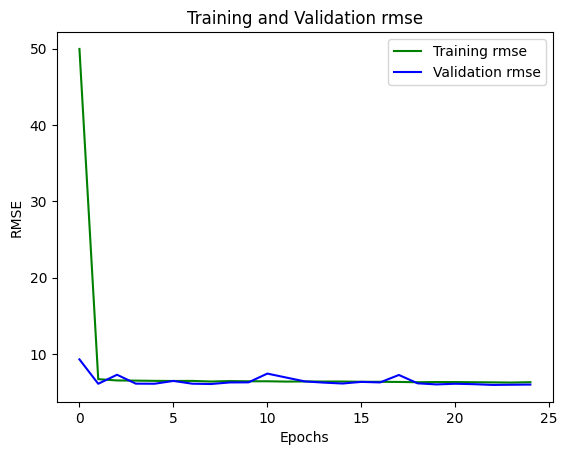

In [ ]:
report(history5,epoch =25)

In [ ]:
y_pred = model.predict(X_test)
rmse = keras.metrics.mean_squared_error(y_test, y_pred)
print(rmse)
#mse = keras.metrics.mean_squared_error(y_test, y_pred , squared=False)
#print("RMSE:", rmse = keras.metrics.mean_squared_error(y_test, y_pred , squared=False))

370/370 [==============================] - 1s 2ms/step
tf.Tensor([78.76346   28.597427  23.774998  ... 81.36405   40.948593   3.1527705], shape=(11819,), dtype=float32)


In [ ]:
history10 = lstmModel(model10, X_train10, X_valid10, y_train10, y_valid10)

Epoch 1/25
2635/2635 [==============================] - 23s 7ms/step - loss: 2557.5828 - root_mean_squared_error: 50.5725 - val_loss: 115.0032 - val_root_mean_squared_error: 10.7240
Epoch 2/25
2635/2635 [==============================] - 18s 7ms/step - loss: 124.2337 - root_mean_squared_error: 11.1460 - val_loss: 116.7289 - val_root_mean_squared_error: 10.8041
Epoch 3/25
2635/2635 [==============================] - 19s 7ms/step - loss: 121.4571 - root_mean_squared_error: 11.0208 - val_loss: 112.5325 - val_root_mean_squared_error: 10.6081
Epoch 4/25
2635/2635 [==============================] - 19s 7ms/step - loss: 121.7692 - root_mean_squared_error: 11.0349 - val_loss: 121.5209 - val_root_mean_squared_error: 11.0237
Epoch 5/25
2635/2635 [==============================] - 19s 7ms/step - loss: 119.4548 - root_mean_squared_error: 10.9295 - val_loss: 106.8302 - val_root_mean_squared_error: 10.3359
Epoch 6/25
2635/2635 [==============================] - 18s 7ms/step - loss: 118.9122 - root_m

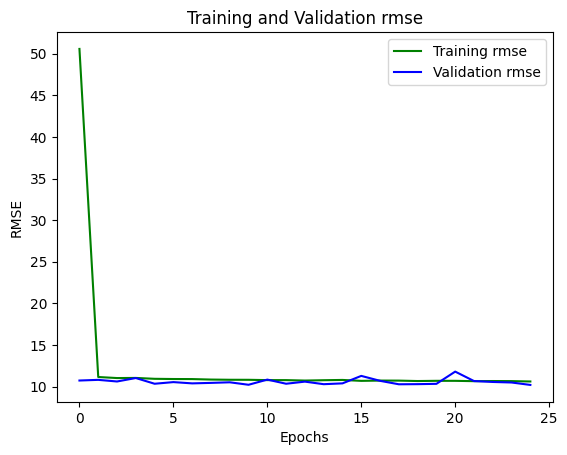

In [ ]:
report(history10,epoch =25)

In [ ]:
y_pred10 = model10.predict(X_test10)
rmse10 = keras.metrics.mean_squared_error(y_test10, y_pred10)
print(rmse10)

366/366 [==============================] - 1s 2ms/step
tf.Tensor(
[ 12.285594  463.31287    37.898006  ...   7.6043515   3.2168713
   3.9591503], shape=(11710,), dtype=float32)


In [ ]:
history15= lstmModel(model15, X_train15, X_valid15, y_train15, y_valid15)

Epoch 1/25
2615/2615 [==============================] - 21s 7ms/step - loss: 3097.5544 - root_mean_squared_error: 55.6557 - val_loss: 228.2167 - val_root_mean_squared_error: 15.1068
Epoch 2/25
2615/2615 [==============================] - 16s 6ms/step - loss: 229.3838 - root_mean_squared_error: 15.1454 - val_loss: 227.0406 - val_root_mean_squared_error: 15.0679
Epoch 3/25
2615/2615 [==============================] - 16s 6ms/step - loss: 224.3773 - root_mean_squared_error: 14.9792 - val_loss: 271.9154 - val_root_mean_squared_error: 16.4899
Epoch 4/25
2615/2615 [==============================] - 19s 7ms/step - loss: 222.1929 - root_mean_squared_error: 14.9061 - val_loss: 228.7843 - val_root_mean_squared_error: 15.1256
Epoch 5/25
2615/2615 [==============================] - 18s 7ms/step - loss: 220.5172 - root_mean_squared_error: 14.8498 - val_loss: 216.3663 - val_root_mean_squared_error: 14.7094
Epoch 6/25
2615/2615 [==============================] - 17s 7ms/step - loss: 220.2644 - root_m

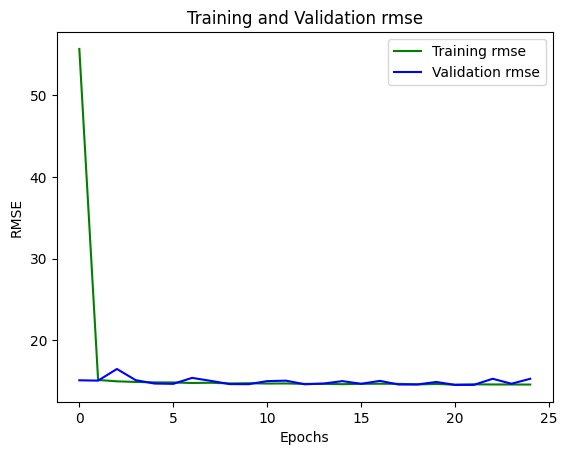

In [ ]:
report(history15,epoch =25)

In [ ]:
y_pred15 = model10.predict(X_test15)
rmse15 = keras.metrics.mean_squared_error(y_test15, y_pred15)
print(rmse15)

364/364 [==============================] - 1s 3ms/step
tf.Tensor([241.13016   19.505304 267.67508  ... 236.88449    8.893839 265.23328 ], shape=(11619,), dtype=float32)
